In [86]:
import numpy as np, pandas as pd, numpy.random as random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as st
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten

We first implement the conditional intensity function for ME (single station).

In [64]:
def cond_int_fun_mutual(t, arr_times, dep_times, param):
    """
    Find the value of the conditional intensity function at time t using given parameters.
    """
    
    para_dep = param["departure"]
    para_arr = param["arrival"]
    beta_dd, theta_dd, beta_ad, theta_ad, lambda_bd = para_dep[0], para_dep[1], para_dep[2], para_dep[3],  para_dep[4]
    beta_da, theta_da, beta_aa, theta_aa, lambda_ba = para_arr[0], para_arr[1], para_arr[2], para_arr[3], para_arr[4]
    
    lambda_td, lambda_ta = lambda_bd, lambda_ba
    ind = np.searchsorted(dep_times, t, side='right')
    if ind > 0:
        dep_times = dep_times[0:ind]
        lambda_td += np.sum(beta_dd * np.exp(-theta_dd*(t-dep_times)))  
        lambda_ta += np.sum(beta_da * np.exp(-theta_da*(t-dep_times)))  
    
    ind1 = np.searchsorted(arr_times, t, side='right')
    if ind1 > 0:
        arr_times = arr_times[0:ind1]
        lambda_td += np.sum(beta_ad * np.exp(-theta_ad*(t-arr_times)))
        lambda_ta += np.sum(beta_aa * np.exp(-theta_aa*(t-arr_times)))  
       
    return lambda_td, lambda_ta

And we plot the conditional intensity functions of two processes.

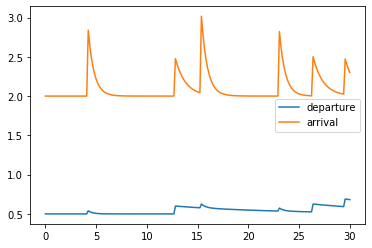

{'arrival': array([ 4.12109391, 15.36496789, 22.9525598 ]), 'departure': array([12.76611743, 26.37711347, 29.44448228])}


In [65]:
event_times = {"arrival": np.sort(random.uniform(0,30,size=3)), "departure": np.sort(random.uniform(0,30,size=3))}
arr_times = event_times["arrival"]
dep_times = event_times["departure"]
t = np.linspace(0, 30, 200)
param = {"arrival": [0.5, 1.0, 1.0, 1.75, 2.0], "departure":[0.1, 0.1, 0.05, 2.25, 0.5]}

lamb_d = []
lamb_a = []

for i in range(len(t)):
    lambda_td, lambda_ta = cond_int_fun_mutual(t[i], arr_times, dep_times, param)
    lamb_d.append(lambda_td)
    lamb_a.append(lambda_ta)
    
    
plt.plot(t, lamb_d, label='departure');
plt.plot(t, lamb_a, label='arrival');
plt.legend()
plt.show();


print(event_times)

We implement the function to simulate from ME (single station).

In [67]:
def mutual_sim(n, param):
    """
    Simulate n event time data using given parameters.
    """

    para_dep = param["departure"]
    para_arr = param["arrival"]
    beta_dd, theta_dd, beta_ad, theta_ad, lambda_bd = para_dep[0], para_dep[1], para_dep[2], para_dep[3],  para_dep[4]
    beta_da, theta_da, beta_aa, theta_aa, lambda_ba = para_arr[0], para_arr[1], para_arr[2], para_arr[3], para_arr[4]
    
    dep_times, arr_times = [], []
    t0 = random.exponential(1/(lambda_bd + lambda_ba), 1)[0]
    
    u = random.uniform(low = 0.0, high = lambda_bd + lambda_ba, size = 1)
    if lambda_bd <= lambda_ba:
        if 0 <= u <= lambda_bd:
            dep_times.append(t0)
        else:
            arr_times.append(t0)
    else:
        if 0 <= u <= lambda_ba:
            arr_times.append(t0)
        else:
            dep_times.append(t0)
    
    lambda_td, lambda_ta = cond_int_fun_mutual(t0, arr_times, dep_times, param)

    while len(dep_times) < n or len(arr_times) < n:
        t1 = t0 + random.exponential(1/(lambda_td + lambda_ta), 1)[0]
        lambda_td_new, lambda_ta_new = cond_int_fun_mutual(t1, arr_times, dep_times, param)
        u = random.uniform(low = 0.0, high = lambda_td + lambda_ta, size = 1)
        if lambda_td <= lambda_ta:
        #if lambda_td_new <= lambda_ta_new:
            if u <= lambda_td_new:
                dep_times.append(t1)
                lambda_td = lambda_td_new + beta_dd
                lambda_ta = lambda_ta_new + beta_da
            elif lambda_td_new < u <= (lambda_td_new + lambda_ta_new):
                arr_times.append(t1)
                lambda_td = lambda_td_new + beta_ad
                lambda_ta = lambda_ta_new + beta_aa 
            else:
                lambda_td = lambda_td_new 
                lambda_ta = lambda_ta_new 
        else :
            if u <= lambda_ta_new:
                arr_times.append(t1)
                lambda_td = lambda_td_new + beta_ad
                lambda_ta = lambda_ta_new + beta_aa
            elif lambda_ta_new < u <= (lambda_td_new + lambda_ta_new):
                dep_times.append(t1)
                lambda_td = lambda_td_new + beta_dd
                lambda_ta = lambda_ta_new + beta_da 
            else:
                lambda_td = lambda_td_new 
                lambda_ta = lambda_ta_new 
        
        t0 = t1
    
    times = {}
    times["arrival"] = arr_times #[0:n]
    times["departure"] = dep_times #[0:n]
    
    return times

We simulate some data using given parameters, and plot the conditional intensity functions.

In [ ]:
para = {1: [0.5, 1.0, 1.0, 1.75, 2.0], 0:[0.1, 0.1, 0.05, 2.25, 0.5]}

times = mutual_sim2(2, para)
arr_times = times[1]
dep_times = times[0]
t = np.linspace(0, 50.0, 200)
lamb_d = []
lamb_a = []

for i in range(len(t)):
    lambda_td, lambda_ta = cond_int_fun_mutual(t[i], arr_times, dep_times, para)
    lamb_d.append(lambda_td)
    lamb_a.append(lambda_ta)
    
plt.plot(t, lamb_d, label='departure');
plt.plot(t, lamb_a, label='arrival');
plt.legend()
plt.show();

print(times)

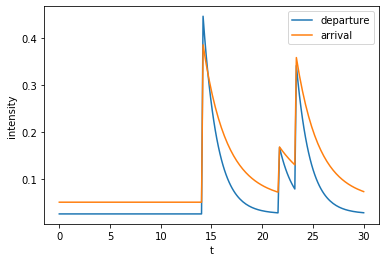

In [123]:
## para = {"arrival": [2.0, 2.15, 1.5, 1.75, 4.0], "departure":[2.5, 2.65, 2.0, 2.25, 4.5]}
para = {'arrival': [0.1, 0.25, 0.25, 0.5, 0.05], 'departure':[0.15, 0.65, 0.3, 0.75, 0.025]}
times = mutual_sim(2, para)
arr_times = times['arrival']
dep_times = times['departure']
t = np.linspace(0, 30, 200)
lamb_d = []
lamb_a = []

for i in range(len(t)):
    lambda_td, lambda_ta = cond_int_fun_mutual(t[i], arr_times, dep_times, para)
    lamb_d.append(lambda_td)
    lamb_a.append(lambda_ta)
    
plt.plot(t, lamb_d, label='departure')
plt.plot(t, lamb_a, label='arrival')
plt.legend()
plt.xlabel('t')
plt.ylabel('intensity')

plt.savefig('SME sim.pdf')
plt.show()

We need some previously implemented functions for optimisations.

In [121]:
def prev_event(times, T):
    """
    Return the event times in process j that happens before event time T in process i.
    : param times: an n-dimensional array, the full event times in process j
    : param T: a number, one event time in process i
    
    : return k: a number, the index of the last event time in process j happened before T in process i
    """
    
    return np.searchsorted(times, T, side='right')

In [73]:
def process_times(dep_times, arr_times):
    """
    Return the event times in both departure process and arrival process at station i, before the last event time
    observed in departure process.
    
    : param dep_times: a 1-D array, the departure times from station i
    : param arr_times: a 1-D array, the arrival times to station i
    
    : return event_times: a dictionary, storing all relevant event times
    """
    
    event_times = {}
    
    event_times["departure"] = dep_times
    event_times["arrival"] = arr_times[: prev_event(arr_times, dep_times[-1])]
    
    return event_times
    

In [74]:
def B_i(theta, dep_times, arr_times):
    """
    Finds the array of function B_i, for all event times in process i
    
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param dep_times, a 1-D array, the event times observed in process i
    : param arr_times, a 1-D array, the event times observed in process j
    
    : return B: a 1D array
    """
    
    B = np.zeros(len(dep_times))
    ind = prev_event(arr_times, dep_times[0])
    
    B[0] = np.sum(np.exp(- theta[1] * (dep_times[0] - arr_times[:ind])))
    
    for h in range(1, len(dep_times)):
        B[h] = np.exp(-theta[1] * (dep_times[h] - dep_times[h-1])) * B[h-1] 
        B[h] += np.sum(np.exp(- theta[1] * (dep_times[h] - arr_times[ind:prev_event(arr_times, dep_times[h])])))
        ind = prev_event(arr_times, dep_times[h])
        
    return B

In [75]:
def A_i(theta, dep_times):
    """
    Finds the array of function A_i, from 1st event to hth event in process i
    
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param dep_times, a 1-D array, the event times observed in process i
    
    : return A: a 1-D array
    """
   
    A = np.zeros(len(dep_times))
    
    for h in range(1, len(dep_times)):
        A[h] = np.exp(-theta[0]*(dep_times[h] - dep_times[h-1]))*(1+A[h-1])
        
    return A

In [76]:
def mutual_log_likelihood(event_times, beta, theta, lambda_b): 
    """
    Finds the log-likelihood of the mutually exciting process at station i
    
    : param event_times: a dictionary, the event times in all processes \
      that occurred before the last event in process i 
    : param beta: a 1-D array of length 2, which stores beta and beta'
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param lambda_b: a real number, the baseline intensity of station i
    
    : return res: a real number, the log likelihood
    """
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    if len(arr_times) == 0:
        raise Exception("Arrival times null")
    
    ratio = beta/theta
    T = dep_times[-1]
    
    A = A_i(theta, dep_times)
    B = B_i(theta, dep_times, arr_times)
    
    first_sum = np.sum(np.log(lambda_b + beta[0]*A + beta[1]*B))
    second_sum = ratio[0] * np.sum(np.exp(-theta[0]*(T - dep_times)) - 1)
    third_sum = 0
    ind = prev_event(arr_times, T)
    if ind != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(T - arr_times[: ind])) - 1)
    res = first_sum + second_sum + third_sum - lambda_b*T
    
    return res

We do simulations of size 500 for 25 times, record the result from maximum likelihood estimation each time, and construct the histogram of the mle parameters.

In [189]:
n = 25
para_arr = np.zeros((n, 5))
para_dep = np.zeros((n, 5))
para = {1: [0.1, 0.25, 0.25, 0.5, 0.05], 0:[0.15, 0.65, 0.3, 0.75, 0.025]}

x0_init_arr = [np.log(0.25), np.log(0.1), np.log(0.5-0.25), np.log(0.25-0.1), np.log(0.05)]
x0_init_dep = [np.log(0.15), np.log(0.3), np.log(0.65-0.15), np.log(0.75-0.3), np.log(0.025)]

for i in range(n):
    print('Iteration: ', i+1, '/',n, end='\r')
    t_dep = mutual_sim2(500, para)
    arr_t = t_dep[1]
    dep_t = t_dep[0]

    t_arr = {}
    t_arr[1] = dep_t
    t_arr[0] = arr_t
    mle_dep = op.minimize(op_mutual_log_likelihood2, x0 = x0_init_dep, method = 'Nelder-Mead', args=(t_dep,))
    mle_arr = op.minimize(op_mutual_log_likelihood2, x0 = x0_init_arr, method = 'Nelder-Mead', args=(t_arr,))
    para_dep[i, :] = mle_dep.x
    para_arr[i, :] = mle_arr.x
    
#para_arr

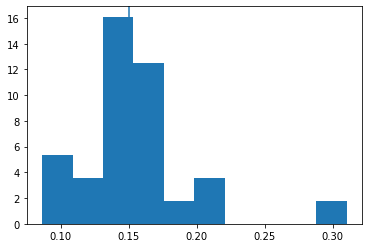

In [190]:
plt.hist(np.exp(para_dep[:n, 0]), density=True)
plt.axvline(x=0.15)
plt.show()

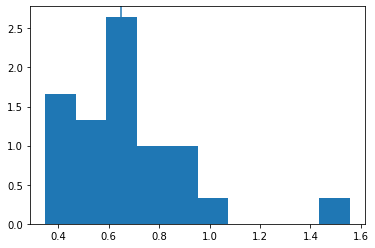

In [191]:
plt.hist(np.exp(para_dep[:n, 0])+ np.exp(para_dep[:n, 2]), density=True)
plt.axvline(x=0.65)
plt.show()

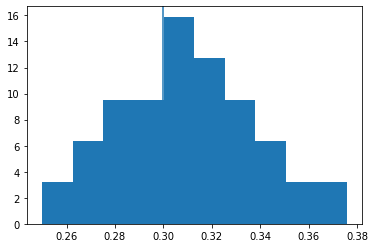

In [192]:
plt.hist(np.exp(para_dep[:n, 1]), density=True)
plt.axvline(x=0.3)
plt.show()

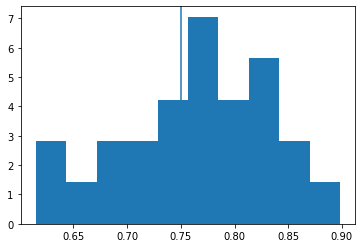

In [193]:
plt.hist(np.exp(para_dep[:n, 1])+ np.exp(para_dep[:n, 3]), density=True)
plt.axvline(x=0.75)
plt.show()

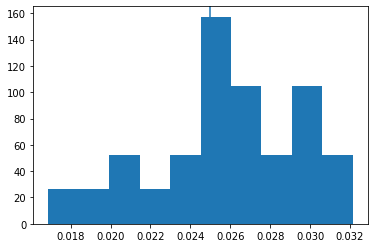

In [194]:
plt.hist(np.exp(para_dep[:n, 4]), density=True)
plt.axvline(x=0.025)
plt.show()

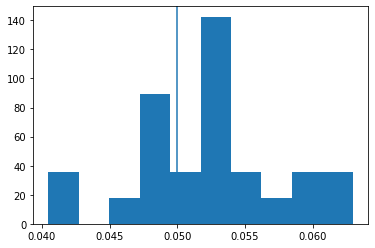

In [195]:
plt.hist(np.exp(para_arr[:n, 4]), density=True)
plt.axvline(x=0.05)
plt.show()

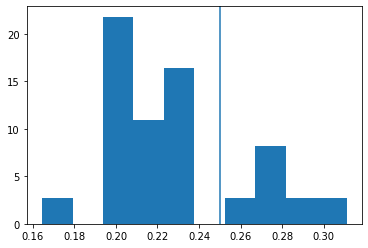

In [196]:
plt.hist(np.exp(para_arr[:n, 0]), density=True)
plt.axvline(x=0.25)
plt.show()

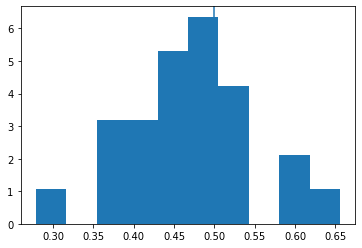

In [197]:
plt.hist(np.exp(para_arr[:n, 0])+ np.exp(para_arr[:n, 2]), density=True)
plt.axvline(x=0.5)
plt.show()

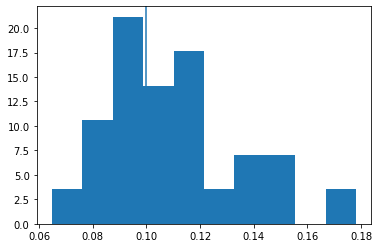

In [198]:
plt.hist(np.exp(para_arr[:n, 1]), density=True)
plt.axvline(x=0.1)
plt.show()

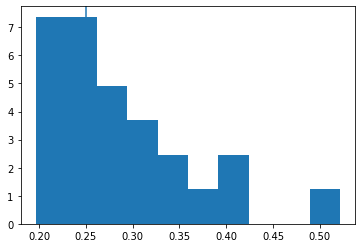

In [199]:
plt.hist(np.exp(para_arr[:n, 1])+ np.exp(para_arr[:n, 3]), density=True)
plt.axvline(x=0.25)
plt.show()

We do simulations of size 500 for 150 times, record the result from maximum likelihood estimation each time, and construct the histogram of the mle parameters. Also, we want to compute the KS statistics.

In [1]:
def mutual_comp(t, event_times, beta, theta, lambda_b): 
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    if len(arr_times) == 0:
        raise Exception("Arrival times null")
    
    ratio = beta/theta
    
    second_sum = 0
    third_sum = 0
    
    ind_dep = prev_event(dep_times, t)
    if ind_dep != 0:
        second_sum += ratio[0] * np.sum(np.exp(-theta[0]*(t - dep_times[: ind_dep])) - 1)
        
    ind_arr = prev_event(arr_times, t)
    if ind_arr != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(t - arr_times[: ind_arr])) - 1)
    res = lambda_b*t - second_sum - third_sum 
    
    return res

In [83]:
def prev_event(times, T):
    """
    Return the event times in process j that happens before event time T in process i.
    : param times: an n-dimensional array, the full event times in process j
    : param T: a number, one event time in process i
    
    : return k: a number, the index of the last event time in process j happened before T in process i
    """
    
    return np.searchsorted(times, T, side='right')

In [88]:
n = 200
para_arr = np.zeros((n, 5))
para_dep = np.zeros((n, 5))

x0_init_arr = [np.log(0.25), np.log(0.1), np.log(0.5-0.25), np.log(0.25-0.1), np.log(0.05)]
x0_init_dep = [np.log(0.15), np.log(0.3), np.log(0.65-0.15), np.log(0.75-0.3), np.log(0.025)]

ks_arr = []
ks_dep = []

for i in range(n):
    print('Iteration: ', i+1, '/',n, end='\r')
    t_dep = mutual_sim(500, para)
    arr_t = t_dep["arrival"]
    dep_t = t_dep["departure"]

    t_arr = {}
    t_arr["arrival"] = dep_t
    t_arr["departure"] = arr_t
    mle_dep = op.minimize(op_mutual_log_likelihood, x0 = x0_init_dep, method = 'Nelder-Mead', args=(t_dep,))
    mle_arr = op.minimize(op_mutual_log_likelihood, x0 = x0_init_arr, method = 'Nelder-Mead', args=(t_arr,))
    para_dep[i, :] = mle_dep.x
    para_arr[i, :] = mle_arr.x
    
    beta_dep1, beta_arr1, theta_dep1, theta_arr1, lambda_b1 = np.exp(mle_dep.x[0]), np.exp(mle_dep.x[1]), np.exp(mle_dep.x[0]) + np.exp(mle_dep.x[2]), np.exp(mle_dep.x[1]) + np.exp(mle_dep.x[3]), np.exp(mle_dep.x[4])
    compensator_t1 = np.zeros(len(t_dep['departure'])+1)
    for i in range(len(t_dep['departure'])):
        compensator_t1[i+1] = mutual_comp(t_dep['departure'][i], t_dep, np.array([beta_dep1, beta_arr1]), np.array([theta_dep1, theta_arr1]), lambda_b1)

    inter_arr_times1 = np.diff(compensator_t1)
    p_values1 = np.exp(-inter_arr_times1)
    ks1 = st.kstest(p_values1, "uniform")
    ks_dep.append(ks1.statistic)
    
    beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle_arr.x[0]), np.exp(mle_arr.x[1]), np.exp(mle_arr.x[0]) + np.exp(mle_arr.x[2]), np.exp(mle_arr.x[1]) + np.exp(mle_arr.x[3]), np.exp(mle_arr.x[4])

    compensator_t2 = np.zeros(len(t_arr['departure'])+1)
    for i in range(len(t_arr['departure'])):
        compensator_t2[i+1] = mutual_comp(t_arr['departure'][i], t_arr, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

    inter_arr_times2 = np.diff(compensator_t2)
    p_values2 = np.exp(-inter_arr_times2)
    ks2 = st.kstest(p_values2, "uniform")
    ks_arr.append(ks2.statistic)
    
    print(ks1.statistic)
    print(ks2.statistic)
#para_arr

0.02567434362265985
0.029417165779541454
0.02789254950537956
0.021595891818702362
0.02906627323006250
0.018585673400315472
0.03455826385950156
0.02699333919286606
0.030943505855130726
0.026273216327122317
0.029274956670971575
0.016628155424540214
0.041613183044863944
0.03187889259189014
0.03570804604152489
0.02515379607840018
0.024532111328374184
0.025847859089177028
0.021612349725099260
0.027818492355133118
0.031412152508326410
0.02416766751929711
0.033302519342749526
0.02509436691978717
0.028836154070923325
0.024577227578718386
0.035117219502318275
0.029208852824868403
0.025457822541279262
0.015749383456159283
0.027715673129380170
0.023005918028723593
0.037405654399968236
0.02002557674406058
0.024342900720254218
0.03148060301779154
0.027422099543279704
0.021664150852298725
0.025128807290760280
0.019911615350157924
0.035013141878560080
0.015431816477088134
0.027304021219240693
0.01990820384473757
0.029448955014334866
0.016093728334682922
0.034273906744361590
0.023445044290544004
0.025

0.0221640209265125400
0.02072182669790601
0.0228116005329740700
0.024960723335913815
0.0304634971246522400
0.029002976432513927
0.0271854906077176330
0.0211516945798077
0.0290765141235830860
0.017707351018506567


In [ ]:
mle_dep.x

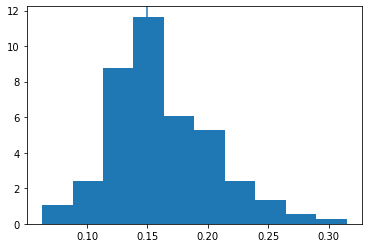

In [136]:
plt.hist(np.exp(para_dep[:n, 0]), density=True)
plt.axvline(x=0.15)
plt.show()

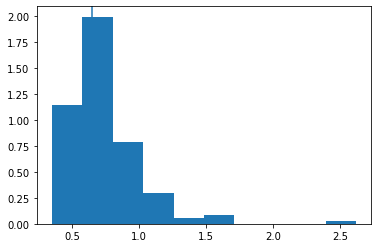

In [137]:
plt.hist(np.exp(para_dep[:n, 0])+ np.exp(para_dep[:n, 2]), density=True)
plt.axvline(x=0.65)
plt.show()

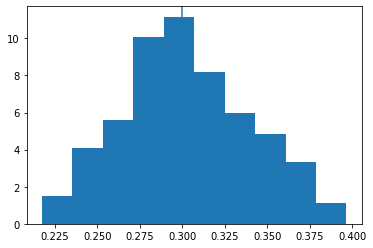

In [138]:
plt.hist(np.exp(para_dep[:n, 1]), density=True)
plt.axvline(x=0.3)
plt.show()

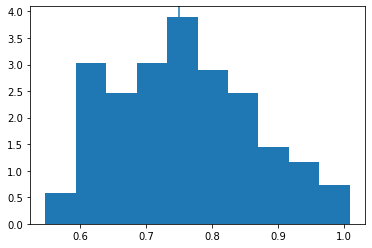

In [139]:
plt.hist(np.exp(para_dep[:n, 1])+ np.exp(para_dep[:n, 3]), density=True)
plt.axvline(x=0.75)
plt.show()

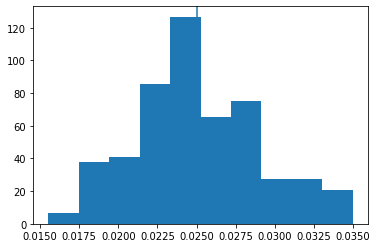

In [140]:
plt.hist(np.exp(para_dep[:n, 4]), density=True)
plt.axvline(x=0.025)
plt.show()

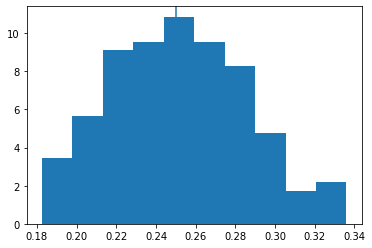

In [141]:
plt.hist(np.exp(para_arr[:n, 0]), density=True)
plt.axvline(x=0.25)
plt.show()

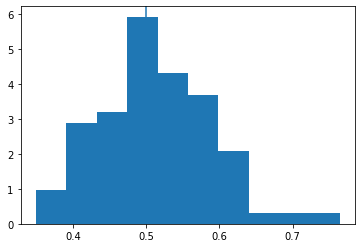

In [142]:
plt.hist(np.exp(para_arr[:n, 0])+ np.exp(para_arr[:n, 2]), density=True)
plt.axvline(x=0.5)
plt.show()

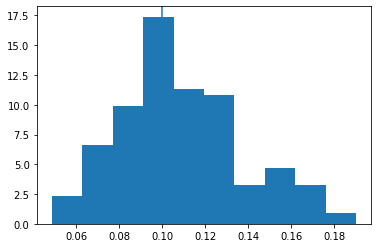

In [143]:
plt.hist(np.exp(para_arr[:n, 1]), density=True)
plt.axvline(x=0.1)
plt.show()

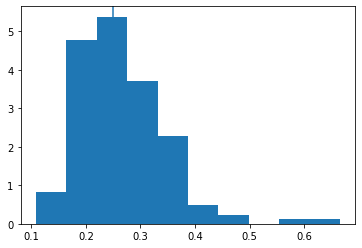

In [144]:
plt.hist(np.exp(para_arr[:n, 1])+ np.exp(para_arr[:n, 3]), density=True)
plt.axvline(x=0.25)
plt.show()

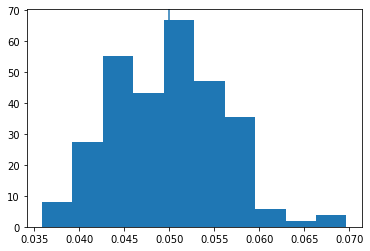

In [145]:
plt.hist(np.exp(para_arr[:n, 4]), density=True)
plt.axvline(x=0.05)
plt.show()

And we put everything into one plot.

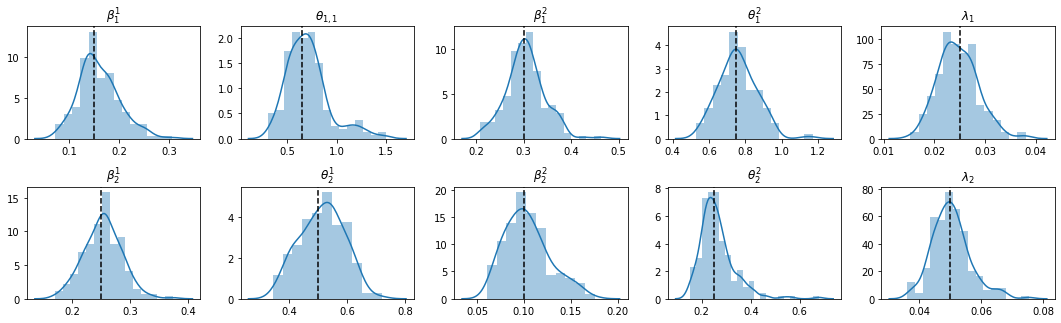

In [125]:
import seaborn as sns
from matplotlib import pyplot as plt
#sns.set()
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

sns.distplot(np.exp(para_dep[:n, 0]), ax=axes[0, 0], hist=True, kde=True)
axes[0, 0].set_title(r'$\beta_1^1$')
axes[0, 0].axvline(0.15, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_dep[:n, 0]) + np.exp(para_dep[:n, 2]), ax=axes[0, 1], hist=True, kde=True)
axes[0, 1].set_title(r'$\theta_{1, 1}$')
axes[0, 1].axvline(0.65, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_dep[:n, 1]), ax=axes[0, 2], hist=True, kde=True)
axes[0, 2].set_title(r'$\beta_1^2$')
axes[0, 2].axvline(0.3, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_dep[:n, 1])+ np.exp(para_dep[:n, 3]), ax=axes[0, 3], hist=True, kde=True)
axes[0, 3].set_title(r'$\theta_1^2$')
axes[0, 3].axvline(0.75, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_dep[:n, 4]) , ax=axes[0, 4], hist=True, kde=True)
axes[0, 4].set_title(r'$\lambda_1$')
axes[0, 4].axvline(0.025, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 0]), ax=axes[1, 0], hist=True, kde=True)
axes[1, 0].set_title(r'$\beta_2^1$')
axes[1, 0].axvline(0.25, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 0])+np.exp(para_arr[:n, 2]), ax=axes[1, 1], hist=True, kde=True)
axes[1, 1].set_title(r'$\theta_2^1$')
axes[1, 1].axvline(0.5, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 1]) , ax=axes[1, 2], hist=True, kde=True)
axes[1, 2].set_title(r'$\beta_2^2$')
axes[1, 2].axvline(0.1, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 1])+ np.exp(para_arr[:n, 3]), ax=axes[1, 3], hist=True, kde=True)
axes[1, 3].set_title(r'$\theta_2^2$')
axes[1, 3].axvline(0.25, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 4]), ax=axes[1, 4], hist=True, kde=True)
axes[1, 4].set_title(r'$\lambda_2$')
axes[1, 4].axvline(0.05, color = 'black', linestyle = '--')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('sme sim.pdf')

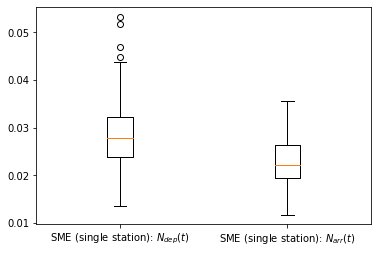

In [117]:
data = [ks_dep, ks_arr]
plt.boxplot(data)

plt.xticks([1, 2], ['SME (single station): ' + r'$N_{dep}(t)$', 'SME (single station): ' + r'$N_{arr}(t)$'])
plt.savefig('sme box.pdf')

In [ ]:
data = [data_1, data_2, data_3, data_4]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()